# DWT Image for MIMO-UNet

In [1]:
from PIL import Image
from einops import rearrange, reduce, repeat
import torch
import torchvision.transforms.functional as F
from pytorch_wavelets import DWTForward, DWTInverse
# from torchmetrics.functional.image import peak_signal_noise_ratio as PSNR
from torchmetrics.image import PeakSignalNoiseRatio as PSNR
from torchmetrics.re


from data import valid_dataloader

In [6]:
def f2i(image):
    # image = 0.5 * image + 0.5
    # float -> uint8
    image = 255 * torch.clip(image, 0, 1.0)
    image = image.to(torch.uint8)
    return image

## Dataloader

In [2]:
dataloader = valid_dataloader(subset='Hday2night', batch_size=8)
data = next(iter(dataloader))
comp, real, mask = data
comp.shape, comp.dtype, mask.shape, mask.dtype, mask.max(), mask.min(), comp.max(), comp.min(), real.max(), real.min()

(torch.Size([8, 3, 256, 256]),
 torch.float32,
 torch.Size([8, 1, 256, 256]),
 torch.float32,
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(-1.),
 tensor(1.),
 tensor(-1.))

In [3]:
psnr1 = PSNR(data_range  = (0.0, 255.0), reduction = "elementwise_mean", dim = (1, 2, 3))
psnr2 = PSNR(data_range  = (-1.0, 1.0), reduction = "elementwise_mean", dim = (1,2,3))

In [7]:
ct = 0.5 * comp + 0.5
rt = 0.5 * real + 0.5
ct = f2i(ct)
rt = f2i(rt)

In [14]:
psnr1(ct, rt)

tensor(36.9194)

## show the dataloader

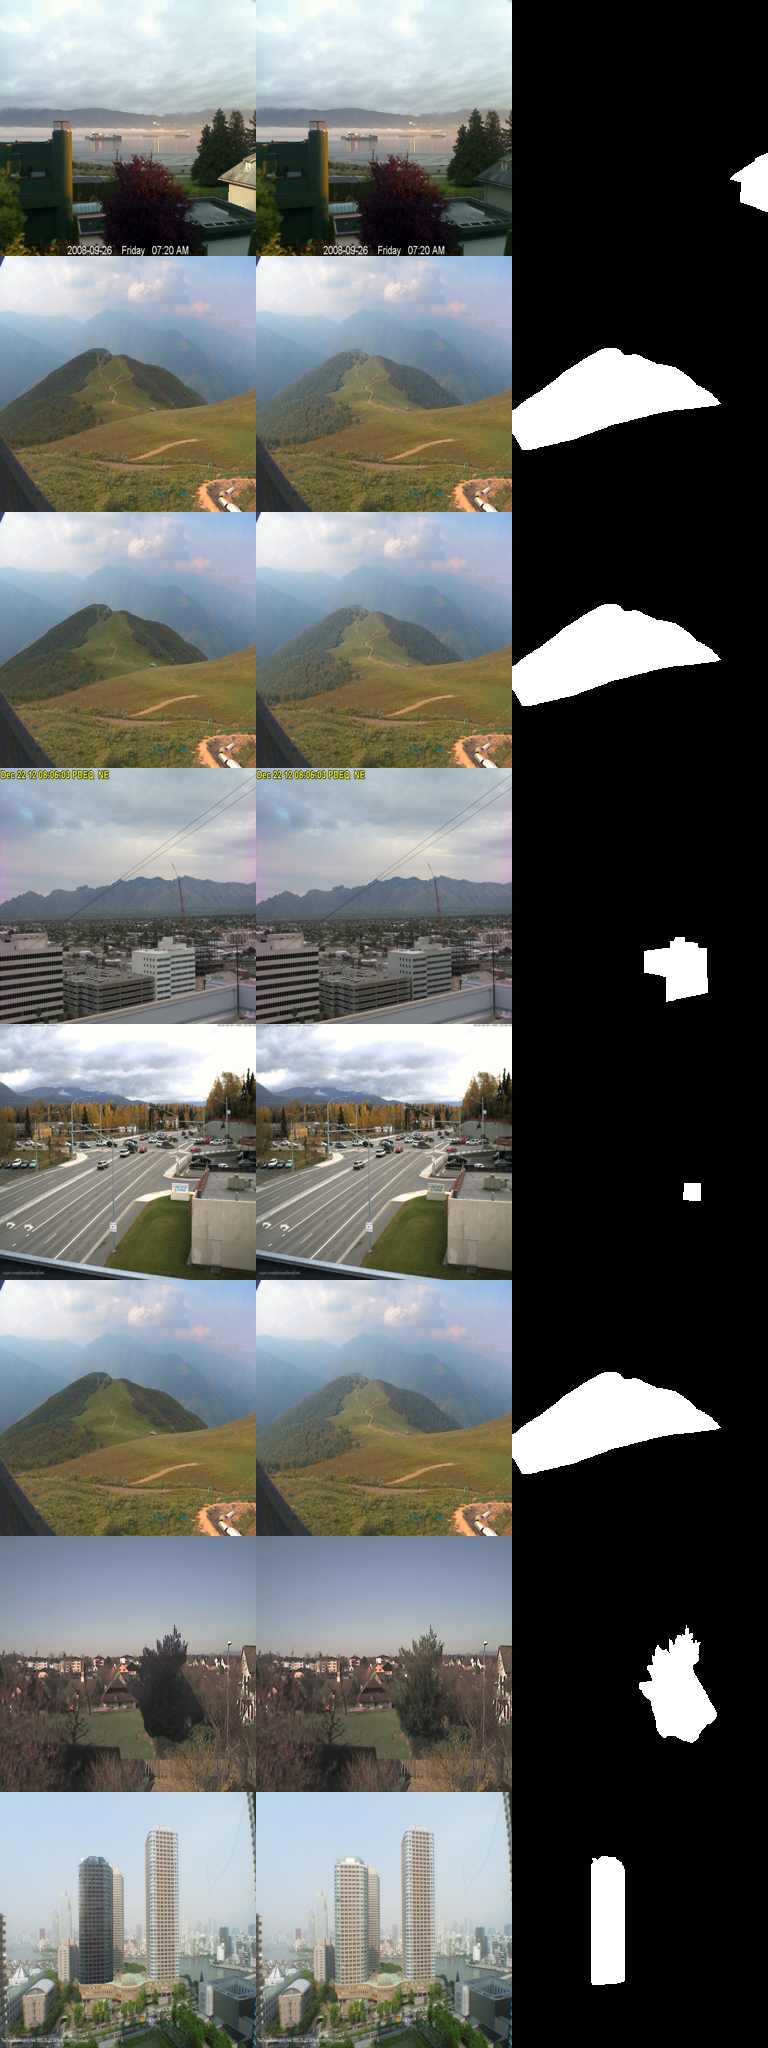

In [7]:
ms = repeat(mask, 'b c h w -> b (n c) h w', n = 3)
cs = 0.5 * comp + 0.5
rs = 0.5 * real + 0.5
img = torch.concat([cs, rs, ms], dim=3)
img_show = f2i(img)
img_show = rearrange(img_show, 'b c h w -> (b h) w c')
img_show = Image.fromarray(img_show.numpy())
img_show.show()

## show low & high Frequency

In [16]:
level = 2
wavelet = 'haar'
# 构建小波变换函数
dwt = DWTForward(J=level, wave=wavelet, mode='zero')
iwt = DWTInverse(wave=wavelet, mode='zero')
yc = dwt(comp)
yr = dwt(real)
# ym = dwt(mask)
ycl, ych = yc
yrl, yrh = yr

# for mask ,use interpolation
yml = F.resize(mask, (64, 64))

ycl.shape, ych[0].shape, 

(torch.Size([8, 3, 64, 64]), torch.Size([8, 3, 3, 128, 128]))

In [22]:
ct = (ycl - ycl.min()) / (ycl.max()-ycl.min())
rt = (yrl - yrl.min()) / (yrl.max()-yrl.min())
ct = f2i(ct)
rt = f2i(rt)
# psnr1.reset()
psnr1(ct, rt)
# 37.6704

tensor(37.6704)

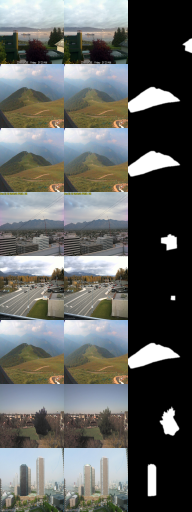

In [9]:
## low frequency show
ms = repeat(yml, 'b c h w -> b (n c) h w', n = 3)
# cs = 0.5 * ycl + 0.5
cs = (ycl - ycl.min()) / (ycl.max() - ycl.min())
rs = (yrl - yrl.min()) / (yrl.max() - yrl.min())
# rs = 0.5 * yrl + 0.5
img = torch.concat([cs, rs, ms], dim=3)
img_show = f2i(img)
img_show = rearrange(img_show, 'b c h w -> (b h) w c')
img_show = Image.fromarray(img_show.numpy())
img_show

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 256, 256])


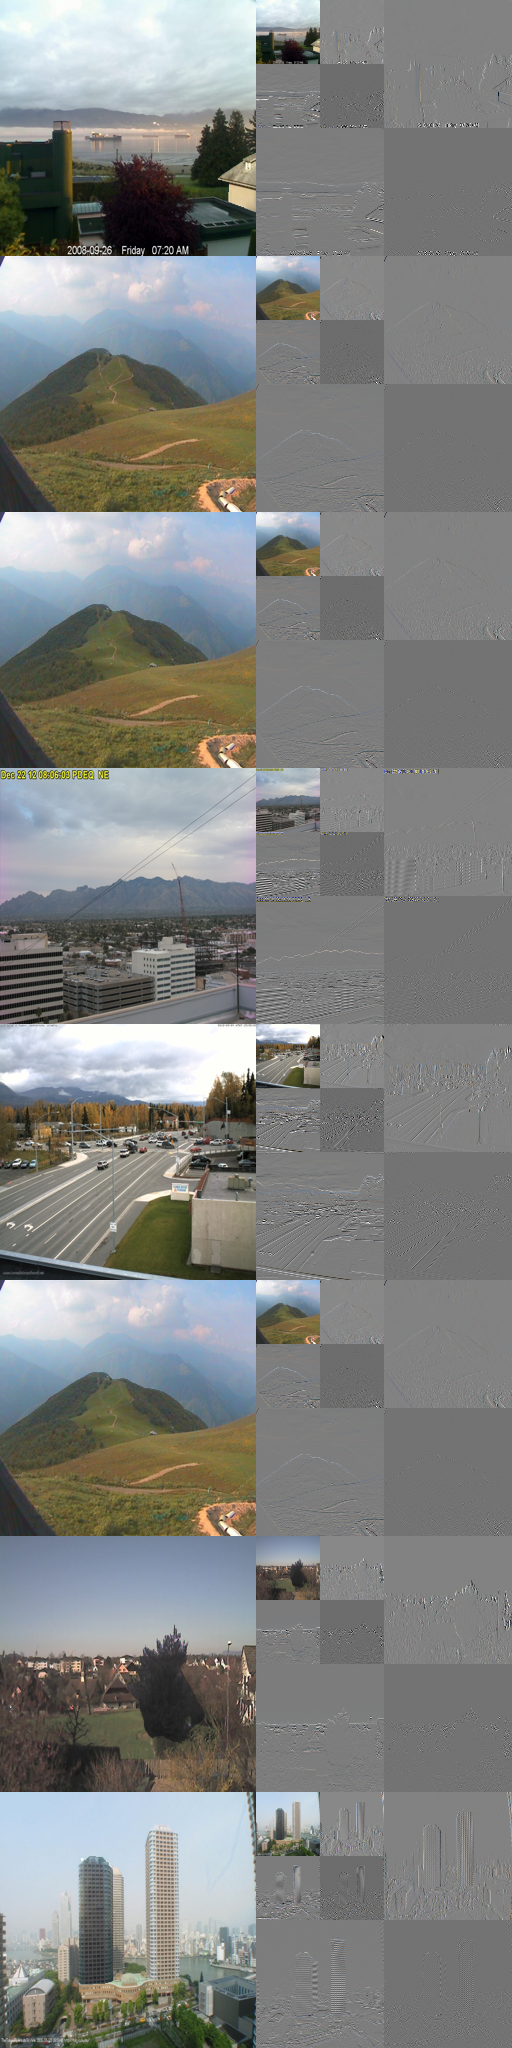

In [20]:
xs = 0.5 * comp + 0.5
xs = rearrange(xs, 'b c h w -> (b h) w c') 
list_ys = [xs]
# for () in ych[::]:
yl, yh = yc
yl = (yl - yl.min()) / (yl.max() - yl.min())
for _yh in yh[::-1]:
    yhv = _yh[:,:,0]
    yhh = _yh[:,:,1]
    yhd = _yh[:,:,2]
    yhh = (yhh - yhh.min()) / (yhh.max() - yhh.min())
    yhv = (yhv - yhv.min()) / (yhv.max() - yhv.min())
    yhd = (yhd - yhd.min()) / (yhd.max() - yhd.min())

    yl = torch.stack([yl, yhh, yhv, yhd], dim=0)
    yl = rearrange(yl, '(m n) b c h w -> b c (m h) (n w)', m=2) 
    print(yl.shape)
ys = rearrange(yl, 'b c h w -> (b h) w c') 
list_ys.append(ys)
ys = torch.concat(list_ys, dim=1)
ys = (255 * ys).to(torch.uint8).numpy()
Image.fromarray(ys)

## DWT for DWTUnet